<a href="https://colab.research.google.com/github/yustiks/video_compression/blob/main/neuralcompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralcompression

In [2]:
!pip install importlib-metadata

In [4]:
import matplotlib.pyplot
import numpy
import torch

from neuralcompression.data import Kodak
from neuralcompression.models import FactorizedPriorAutoencoder
from neuralcompression.models import ScaleHyperpriorAutoencoder
import skimage.data
import skimage.transform
import torchvision.transforms
from PIL import Image
import urllib.request

Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py37_cu111/_pmf_to_quantized_cdf...
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/_pmf_to_quantized_cdf/build.ninja...
Building extension module _pmf_to_quantized_cdf...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _pmf_to_quantized_cdf...


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

     |████████████████████████████████| 11.3 MB 5.1 MB/s 
     |████████████████████████████████| 112 kB 48.7 MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009736 sha256=a71dfe3ec3ed40738ab26e99a9befc1407274dba57ac226593db349e4707fdd1
  Stored in directory: /root/.cache/pip/wheels/51/53/67/d76ff9fd54dd89a25efce20d2e7c9b35348db386b53deb8095
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35432 sha256=6795df112e05ee9b77870b6adc56f7cde3412d9b8c14a90c9b07520ccb5c8180
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [ ]:
from PIL import Image

for i in range(1, 11):
  im = Image.open('/content/' + str(i) + '.jpg')
  im.save('/content/' + str(i) + '.png')

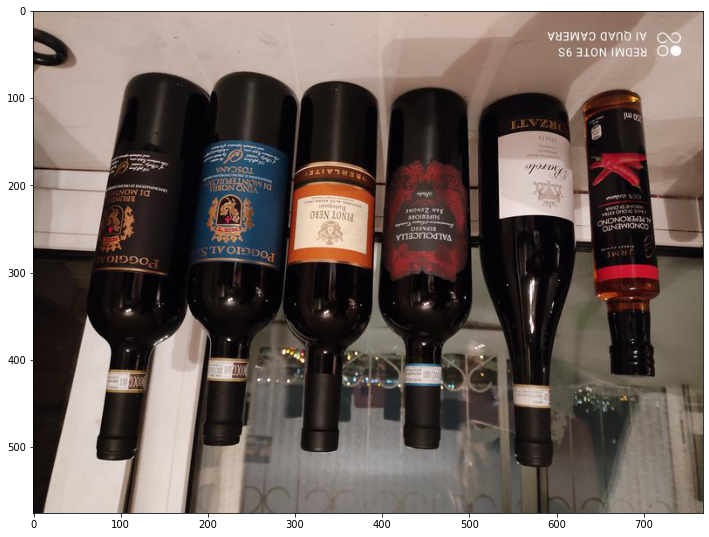

In [7]:
file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_png/"
x = Image.open(file_name + '1.png')

transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float32),
])

x = transform(x).unsqueeze(0)

matplotlib.pyplot.figure(figsize=(12, 18))

matplotlib.pyplot.imshow(x.squeeze().permute(1, 2, 0))

In [8]:
network = FactorizedPriorAutoencoder()

url = "https://dl.fbaipublicfiles.com/neuralcompression/models/factorized_prior_vimeo_90k_mse_128_192_0_025.pth"

state_dict = torch.hub.load_state_dict_from_url(url)

network.load_state_dict(state_dict, strict=False)

Downloading: "https://dl.fbaipublicfiles.com/neuralcompression/models/factorized_prior_vimeo_90k_mse_128_192_0_025.pth" to /root/.cache/torch/hub/checkpoints/factorized_prior_vimeo_90k_mse_128_192_0_025.pth


  0%|          | 0.00/11.7M [00:00<?, ?B/s]

In [9]:
with torch.no_grad():
    strings, broadcast_size = network.compress(x)

sys.getsizeof() on the other hand returns the memory size of the object, this means you are not only getting the size of the bytes, as it a full object it also has its methods, attributes, addresses... which are all considered in that size.

In [10]:
import sys
print(sys.getsizeof(x))
print(sys.getsizeof(strings))

88
80


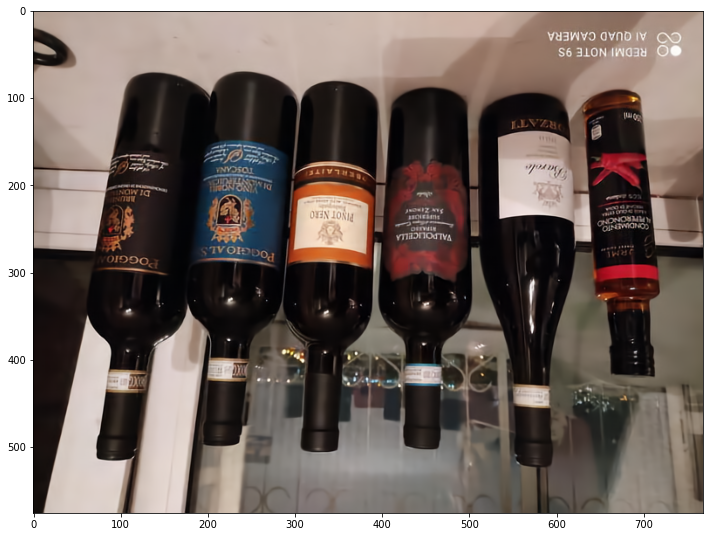

In [11]:
with torch.no_grad():
    x_hat = network.decompress(strings, broadcast_size)

matplotlib.pyplot.figure(figsize=(12, 18))

matplotlib.pyplot.imshow(x_hat.squeeze().permute(1, 2, 0))

matplotlib.pyplot.show()

In [ ]:
from PIL import Image
import numpy as np

for i in range(1, 11):
  file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/"
  img = Image.open(file_name + str(i) + '.jpg')
  img.save("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/" + str(i) + '.bmp')

In [12]:
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity


In [13]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

In [26]:
import numpy as np
import os
import torchvision

for i in range(1, 11):
  file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_png/"
  x = Image.open(file_name + str(i) + '.png')

  transform = torchvision.transforms.Compose([
      torchvision.transforms.PILToTensor(),
      torchvision.transforms.ConvertImageDtype(torch.float32),
  ])

  x = transform(x).unsqueeze(0)
  with torch.no_grad():
      strings, broadcast_size = network.compress(x)
  with torch.no_grad():
      x_hat = network.decompress(strings, broadcast_size)
      torchvision.utils.save_image(x_hat, str(i) + '_decompressed.png')
  x = np.squeeze(x).permute(1, 2, 0).cpu().numpy()
  x = interval_mapping(x, 0.0, 1.0, 0, 255).astype('uint8')
  img_to_save = Image.fromarray(x)
  img_to_save.save(os.path.join('/content/drive/MyDrive/Deelvin_docs/image_compression/neural_compression/'+str(i)+".png"))
  
  x_hat = np.squeeze(x_hat).permute(1, 2, 0).cpu().numpy()
  x_hat = interval_mapping(x_hat, 0.0, 1.0, 0, 255).astype('uint8')
  MSE = mean_squared_error(x, x_hat)
  PSNR = peak_signal_noise_ratio(x, x_hat)
  SSIM = structural_similarity(x, x_hat, multichannel=True)
  print('MSE: ', round(MSE, 4))
  print('PSNR: ', round(PSNR, 2))
  print('MSSIM: ', round(SSIM, 4))

MSE:  27.5351
PSNR:  33.73
MSSIM:  0.9464
MSE:  18.5039
PSNR:  35.46
MSSIM:  0.9534
MSE:  24.8687
PSNR:  34.17
MSSIM:  0.9504
MSE:  24.4058
PSNR:  34.26
MSSIM:  0.9502
MSE:  25.0536
PSNR:  34.14
MSSIM:  0.9483
MSE:  24.218
PSNR:  34.29
MSSIM:  0.9523
MSE:  25.2769
PSNR:  34.1
MSSIM:  0.9541
MSE:  26.0823
PSNR:  33.97
MSSIM:  0.952
MSE:  14.5124
PSNR:  36.51
MSSIM:  0.9617
MSE:  22.5503
PSNR:  34.6
MSSIM:  0.9537


In [22]:
import numpy as np
import torchvision

for i in range(1, 11):
  file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_png/"
  x = Image.open(file_name + str(i) + '.png')

  transform = torchvision.transforms.Compose([
      torchvision.transforms.PILToTensor(),
      torchvision.transforms.ConvertImageDtype(torch.float32),
  ])

  x = transform(x).unsqueeze(0)
  with torch.no_grad():
      strings, broadcast_size = network.compress(x)
      print(sys.getsizeof(strings)*8)
      print(len(strings[0][0])/1327104)

640
0.020161193094135804
640
0.017789110725308643
640
0.019817587770061727
640
0.019763334297839507
640
0.019820601851851853
640
0.01821711033950617
640
0.018708405671296297
640
0.01886212384259259
640
0.016203703703703703
640
0.018147786458333332


## Evaluation

### PSNR

In [ ]:
import math

from torch import Tensor

import torch.nn.functional as F



def psnr(x: Tensor, x_hat: Tensor) -> float:
    return -10 * math.log10(F.mse_loss(x, x_hat).item())


In [ ]:
# coding=utf-8
import cv2
import numpy as np


def calcEntropy(img):
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    return sum_en


if __name__ == '__main__':
    img1 = cv2.imread("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/1.bmp", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/2.bmp", cv2.IMREAD_GRAYSCALE)

    entropy1 = calcEntropy(img1)
    entropy2 = calcEntropy(img2)

    print(entropy1)

[7.54402611]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
import os
for i in range(1, 11):
  file_stats = os.stat("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/" + str(i) + ".bmp")
  #print(f'File Size in Bytes is {file_stats.st_size}')
  print((file_stats.st_size * 8) / (576*768))

24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625
24.0009765625


General answer:

Bits per pixel = Bits/Pixel, 1 Byte = 8 Bits

In [ ]:
for i in range(1, 11):
  print('N_compression = ', int(os.stat(strings).st_size)/int(os.stat('/content/' + str(i) + '.png').st_size))

TypeError: ignored